In [1]:
from gwpy.timeseries import TimeSeries
gwpy_strain = TimeSeries.read('challenge1.gwf', channel="H1:CHALLENGE1")


/opt/conda/lib/python3.8/site-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(True)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


In [2]:
from pycbc import frame
pycbc_strain = frame.read_frame('challenge1.gwf', 'H1:CHALLENGE1')


PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


128.0
4096.0
2.0145972191403612e-29 ct / Hz(1/2)
7.678955173853572e-23 ct / Hz(1/2)


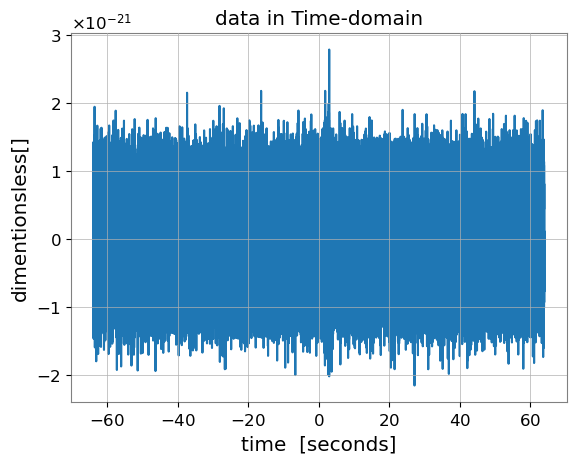

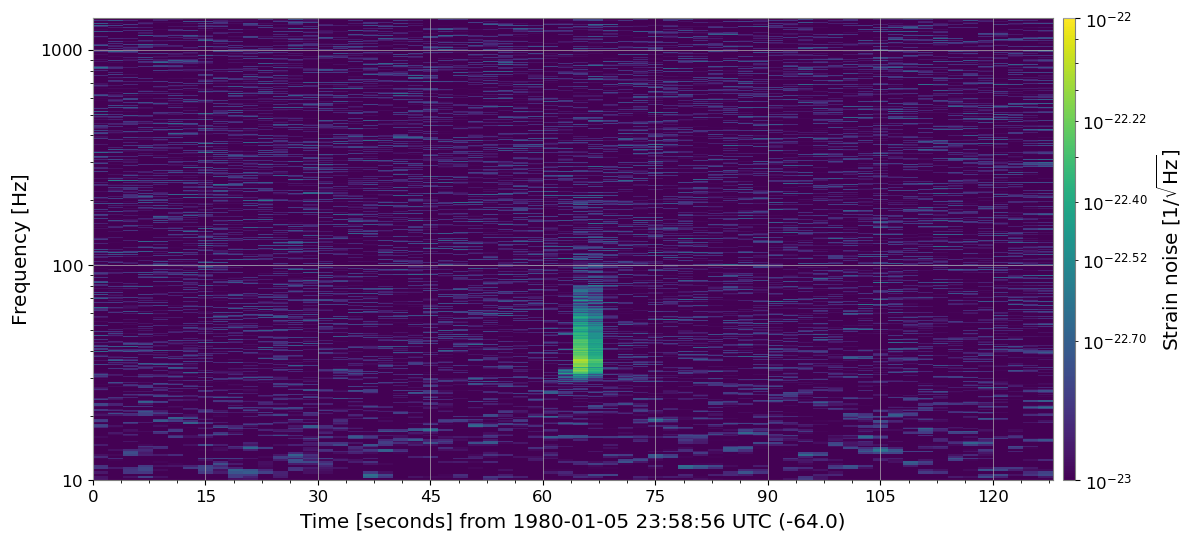

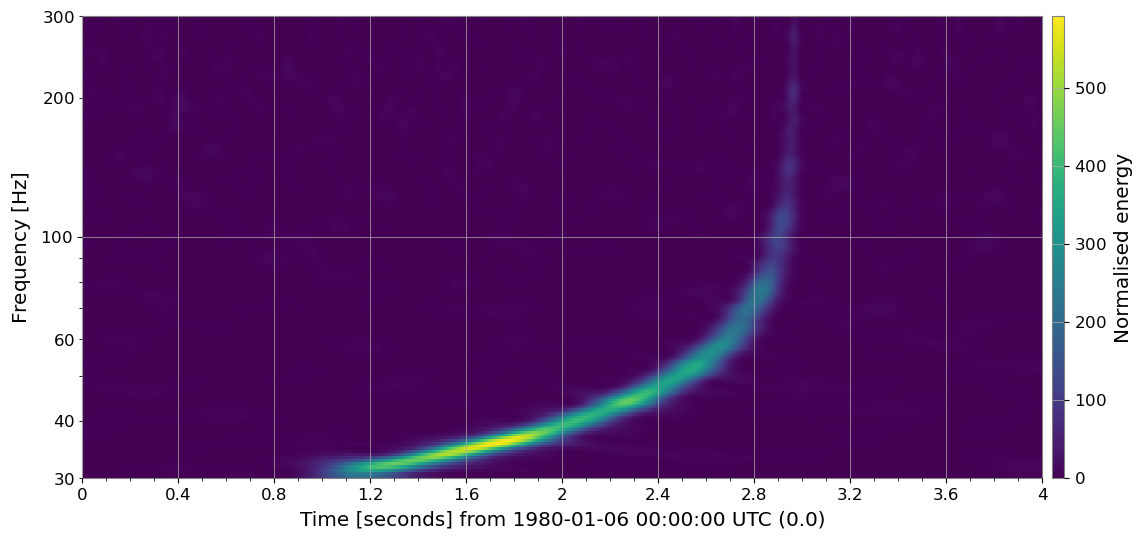

In [3]:
from gwosc.datasets import event_gps
from gwpy.timeseries import TimeSeries
#finds both the duration and the sample rate
print(pycbc_strain.duration)
print(pycbc_strain.get_sample_rate())

#plots the data in function of time
import matplotlib.pyplot as plt
plot = pycbc_strain.plot()
plt.xlabel('time  [seconds]')
plt.ylabel('dimentionsless[]')
plt.title('data in Time-domain')


#plots a spectogram of the data
specgram = gwpy_strain.spectrogram2(fftlength=4, overlap=2, window='hann') ** (1/2.)
plot = specgram.plot()

#finds the min and max value
print(specgram.min())
print(specgram.max())

#zooms in on the spectogram/strains the noise 
ax = plot.gca()
ax.set_yscale('log')
ax.set_ylim(10, 1400)
ax.colorbar(
    clim=(1e-23, 1e-22),
    norm="log",
    label=r"Strain noise [$1/\sqrt{\mathrm{Hz}}$]",
)

#q-transform plot
Fq = gwpy_strain.q_transform(frange=(30, 300), qrange=(10, 100),outseg=(0,4))
plot = Fq.plot()
ax = plot.gca()
ax.set_yscale('log')
ax.colorbar(label="Normalised energy")

#the merger time would be approximetely at 3 seconds given that the peak is at 6 seconds UTC (-3.0)

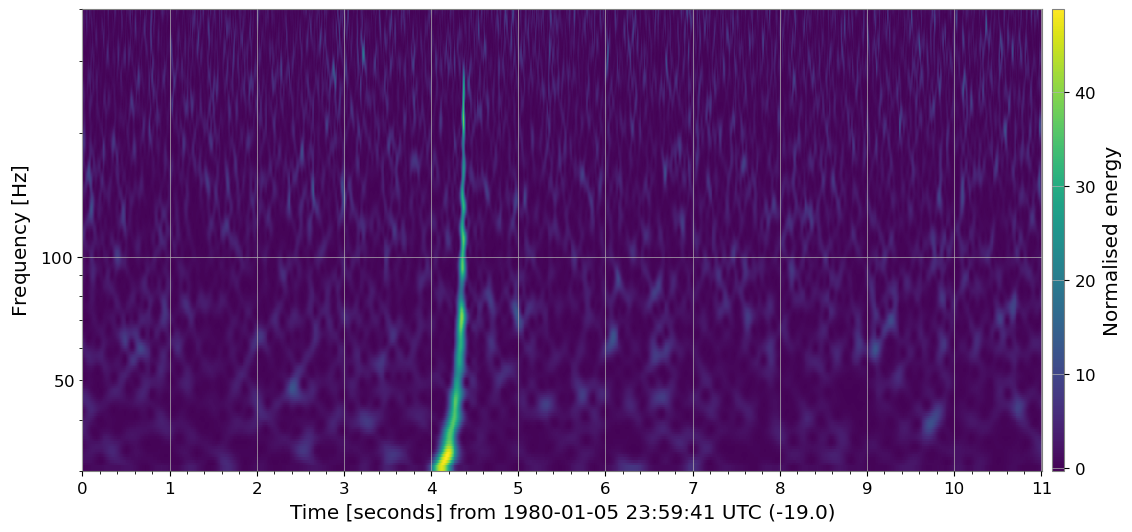

In [4]:
#challenge 2
#import data 2
from pycbc import frame
pycbc_strain2 = frame.read_frame('challenge2.gwf', 'H1:CHALLENGE2')


from gwpy.timeseries import TimeSeries
gwpy_strain2 = TimeSeries.read('challenge2.gwf', channel="H1:CHALLENGE2")

#make q-transform plot
Fq2 = gwpy_strain2.q_transform(frange=(30, 400), qrange=(20, 100),outseg=(-19,-8))
plot = Fq2.plot()
ax = plot.gca()
ax.set_yscale('log')
ax.colorbar(label="Normalised energy")

#the approximate time for the merger is at -14.5 seconds

In [5]:
#import of usefull libraries
from pycbc.waveform import get_td_waveform, get_fd_waveform
import pylab
     
#define the sample rate
sample_rate = pycbc_strain2.get_sample_rate()
print("Sample Rate:",sample_rate)


Sample Rate: 4096.0


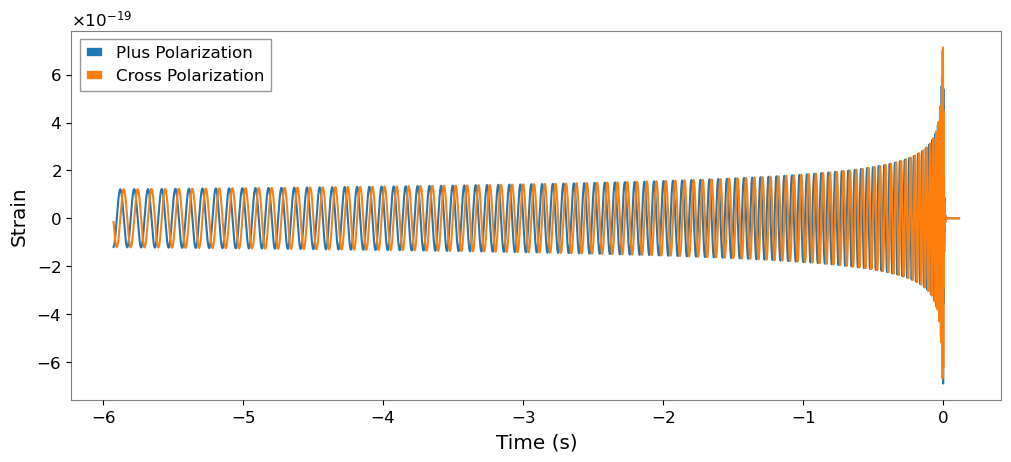

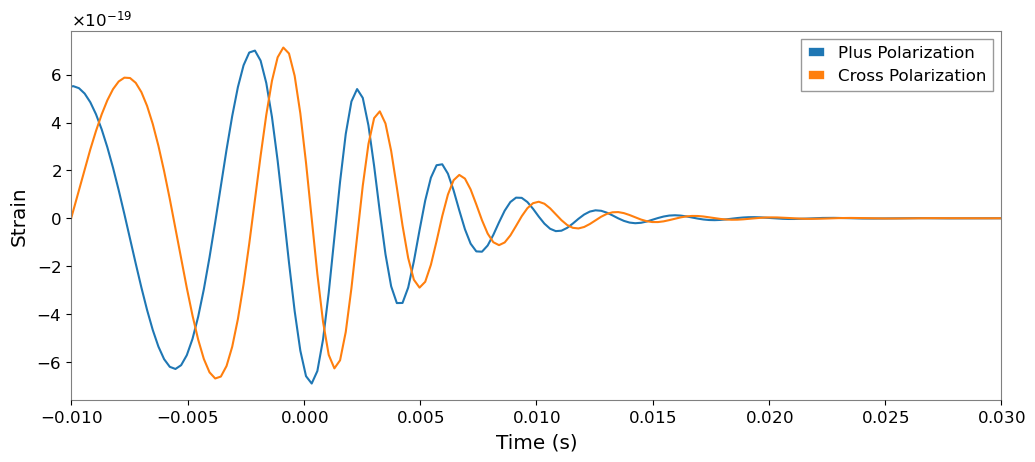

In [6]:
#define variable
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=30,
                         mass2=30,
                         delta_t=1.0/sample_rate,
                         f_lower=10)
#spin nwill not be included because it is 0


pylab.figure(figsize=pylab.figaspect(0.4))
pylab.plot(hp.sample_times, hp, label='Plus Polarization')
pylab.plot(hp.sample_times, hc, label='Cross Polarization')
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
pylab.legend()
pylab.grid()
pylab.show()

# Zoom in near the merger time
pylab.figure(figsize=pylab.figaspect(0.4))
pylab.plot(hp.sample_times, hp, label='Plus Polarization')
pylab.plot(hp.sample_times, hc, label='Cross Polarization')
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
pylab.xlim(-.01, .03)
pylab.legend()
pylab.grid()
pylab.show()


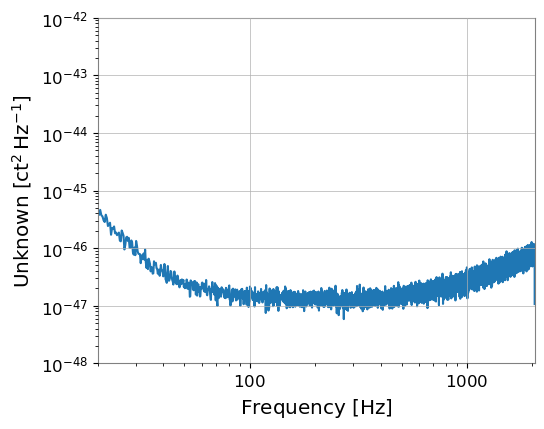

In [7]:
# nyquist frequency is defined as half the sample rate
nyquist_f = sample_rate/2

#plotting the psd
psd = gwpy_strain2.psd(fftlength=4, method="median")
plotpsd = psd.plot()
ax = plotpsd.gca()
ax.set_xlim(20, nyquist_f)

ax.set_ylim(1e-48, 1e-42)
ax.set_yscale("log")

In [8]:
import pylab
#importing more usefull libraries
import pylab
from pycbc.filter import resample_to_delta_t, highpass
from pycbc.psd import interpolate, inverse_spectrum_truncation


#apply highpass to remove low-frequency noise
high = highpass(pycbc_strain2, 15.0)
     

conditioned = high.crop(2, 2)
len(conditioned)

507904

In [9]:
#importing more usefull libraries
psd = conditioned.psd(4)
psd = interpolate(psd, conditioned.delta_f)
psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),
                                  low_frequency_cutoff=15)

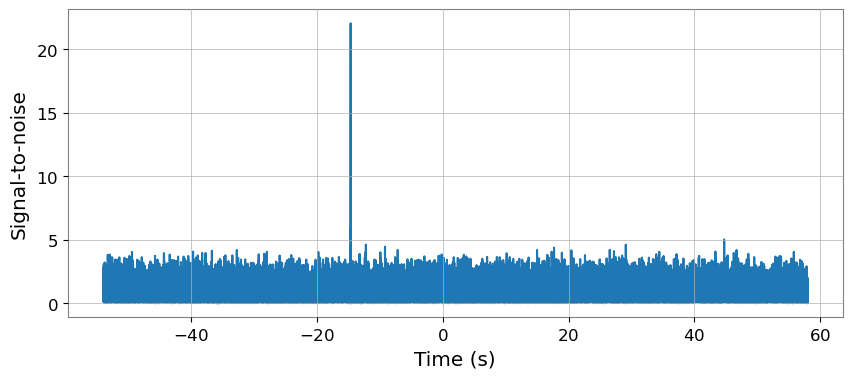

In [10]:
m = 30 # Solar masses
delta_t = 1.0/sample_rate
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m,
                     mass2=m,
                     delta_t=conditioned.delta_t,
                     f_lower=20)

# Resize the vector to match our data
hp.resize(len(conditioned))

template = hp.cyclic_time_shift(hp.start_time)
len(template)

from pycbc.filter import matched_filter
import numpy

#properly plotting everything
snr = matched_filter(template, conditioned,
                     psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4)

# taking an abs() to maximise over the phase of the signal
pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

In [11]:
#as seen on the signle to noise graph the approximate time for the merger is at -14.5 seconds. Which is the same as we saw in the q-transform graph.

Text(0, 0.5, 'strain')

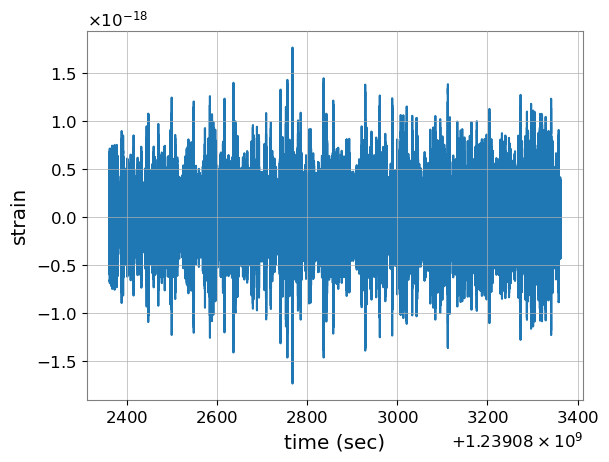

In [66]:
'''
Loading the data and converting the data type into time
series
'''
import numpy as np
import pycbc
from pycbc.types import FrequencySeries, TimeSeries
from pycbc.filter import matched_filter
from pycbc.psd import welch
import matplotlib.pyplot as plt
d = np.load('noise_ts_4096Hz.npy')
time = d[:, 0]
d = pycbc.types.TimeSeries(d[:, 1], delta_t = time[1]-time[0])
data = d

sample_rate = d.sample_rate
nyquist_f = sample_rate/2

plt.plot(time, data)
plt.xlabel('time (sec)')
plt.ylabel('strain')

In [80]:
#Function that generates a waveform based on the mass parameter
#since we are matching the template to a dataset we resize it to match the length

high = highpass(d, 15.0)
conditioned = high.crop(4,4)
def waveform():
    hp, hc = get_td_waveform(approximant="TaylorF2", 
                         mass1=8, mass2=8, 
                         f_lower=20, delta_t=conditioned.delta_t)
    hp.resize(len(conditioned))
    return hp
template = waveform()
fs = conditioned.to_frequencyseries()
length = int(2/conditioned.delta_t)
w = welch(conditioned,length, int(length/2) )
psd = interpolate(w, fs.delta_f)

Text(0, 0.5, 'PSD')

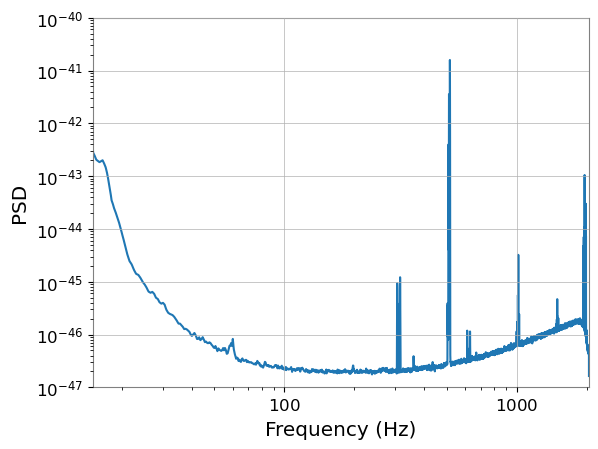

In [81]:
plt.loglog(psd.sample_frequencies,psd)
plt.xlim(15,nyquist_f); plt.ylim(1e-47,1e-40)
plt.xlabel('Frequency (Hz)'); plt.ylabel('PSD')

In [61]:

snr = matched_filter(template,conditioned,psd=psd,low_frequency_cutoff=25)


([<matplotlib.lines.Line2D at 0x7f2b790b41f0>],
 [<matplotlib.lines.Line2D at 0x7f2b790b4490>])

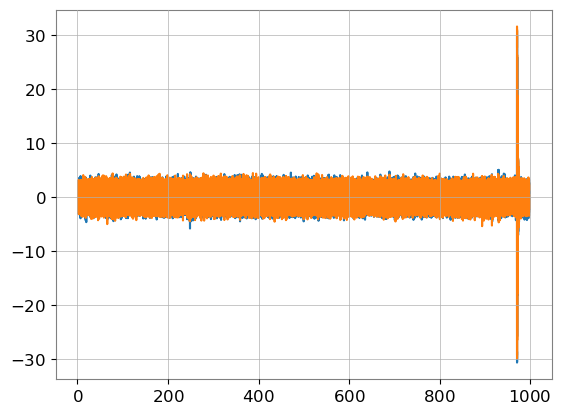

In [63]:
snr.plot()

In [84]:
from scipy.stats import norm

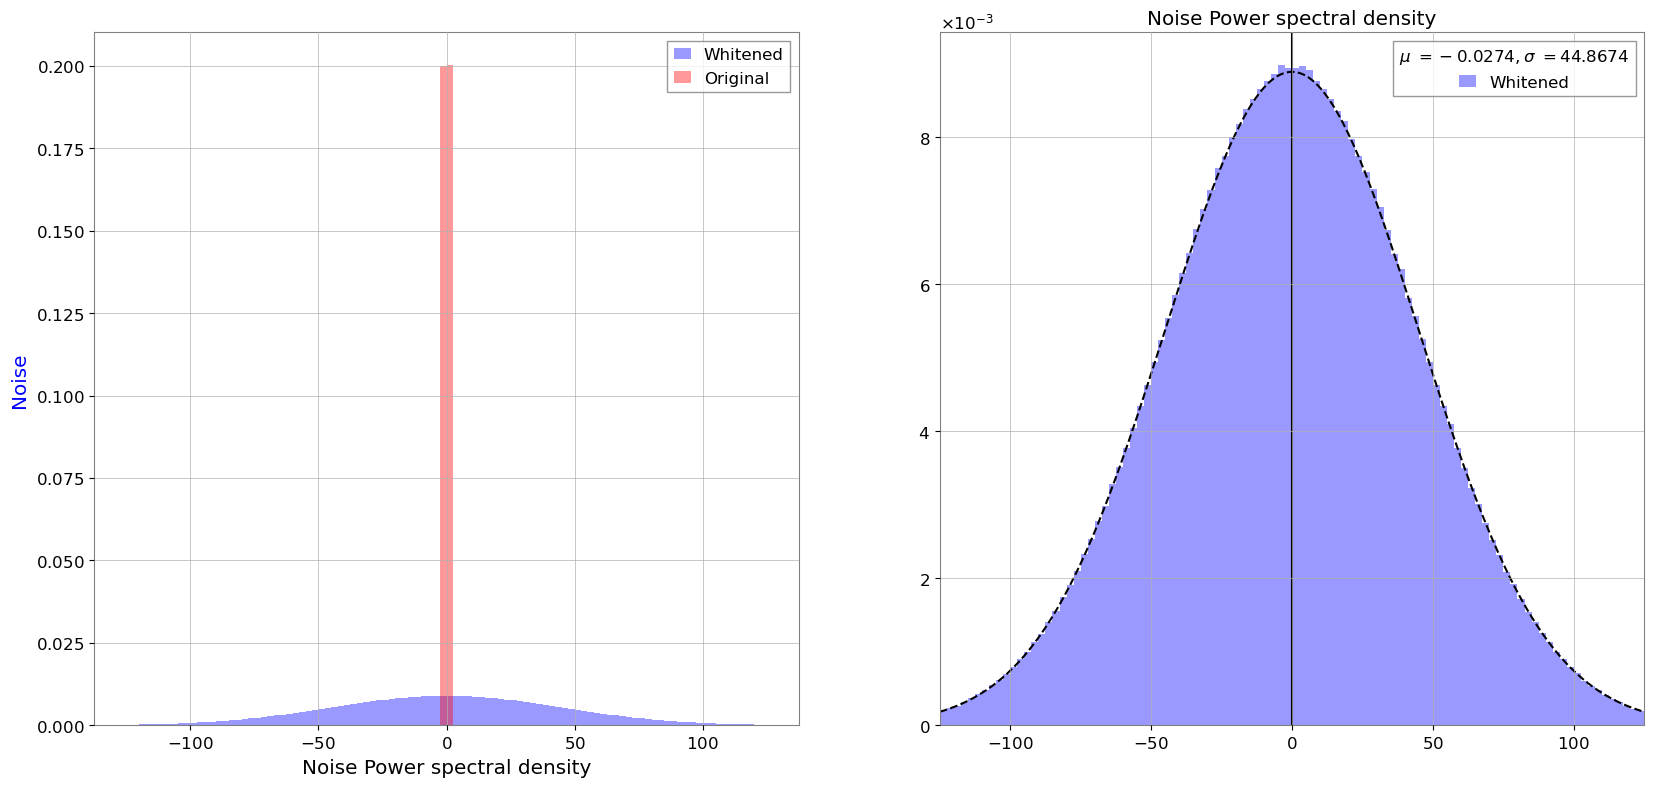

In [85]:
white_data = (conditioned.to_frequencyseries()/psd**0.5).to_timeseries()
white_data = white_data.crop(4,4)

mean = np.mean(white_data)
std = np.std(white_data)
x = np.arange(-125,125)

fig, (ax1, ax2) = plt.subplots(figsize=(20,9),ncols=2)
ax1.set_xlabel('Noise Power spectral density')
ax1.set_ylabel('Noise', color="b")
ax1.hist(white_data, bins=100, range =(-125,125), color="b", alpha=0.4, label ="Whitened", density = True);
ax1.hist(conditioned, bins=100, range =(-125,125), color="r", alpha=0.4, label ="Original", density = True);
ax1.legend()

ax2.set_xlim((-125,125))
plt.title("Noise Power spectral density")

ax2.hist(white_data, bins=100, range =(-125,125), color="b", alpha=0.4, label ="Whitened", density=True);

ax2.plot(x,norm.pdf(x,mean, std),color='k', ls="--")
ax2.axvline(0, c='k')

ax2.legend(title="".join(f'$\mu\ = {round(mean,4)}, \sigma\ ={round(std, 4)}$'))
plt.show()

In [106]:
from pycbc.filter import sigma
from pycbc.psd import estimate

In [112]:
seg_dur = 4
seg_overlap = 2
chunk_duration = 32
n_chunks =  int(np.ceil(white_data.duration / chunk_duration))
length = int(2/white_data.delta_t)
w = welch(white_data,length, int(length/2) )
psd = interpolate(w, white_data.delta_f)

df = white_data.sample_rate / len(white_data)
f = np.arange(len(data) / 2 + 1) * df
hp, hc = get_fd_waveform(approximant="TaylorF2",
                        mass1=3,
                        mass2= 3, 
                        delta_f=df,
                        distance = 500,
                        f_lower=20.0,
                        f_final = 2048)

snrs = []
for i in range(n_chunks)[0:-2]:
    # Extract the chunk of data
    t_start = white_data.start_time + i * chunk_duration
    t_end = white_data.start_time + (i + 1) * chunk_duration
    chunk = white_data.time_slice(t_start, t_end)

    # Calculate the SNR
    rho = sigma(hp, psd=psd, low_frequency_cutoff=20)
    snrs.append(rho)

snrs

[8.204170940449886e-23,
 8.204170940449886e-23,
 8.204170940449886e-23,
 8.204170940449886e-23,
 8.204170940449886e-23,
 8.204170940449886e-23,
 8.204170940449886e-23,
 8.204170940449886e-23,
 8.204170940449886e-23,
 8.204170940449886e-23,
 8.204170940449886e-23,
 8.204170940449886e-23,
 8.204170940449886e-23,
 8.204170940449886e-23,
 8.204170940449886e-23,
 8.204170940449886e-23,
 8.204170940449886e-23,
 8.204170940449886e-23,
 8.204170940449886e-23,
 8.204170940449886e-23,
 8.204170940449886e-23,
 8.204170940449886e-23,
 8.204170940449886e-23,
 8.204170940449886e-23,
 8.204170940449886e-23,
 8.204170940449886e-23,
 8.204170940449886e-23,
 8.204170940449886e-23,
 8.204170940449886e-23]